<table width="100%">
    <tr style="border-bottom:solid 2pt #009EE3">
        <td class="header_buttons">
            <a href="center_of_pressure.zip" download><img src="../../images/icons/download.png" alt="biosignalsnotebooks | download button"></a>
        </td>
        <td class="header_buttons">
            <a href="https://mybinder.org/v2/gh/biosignalsplux/biosignalsnotebooks/mybinder_complete?filepath=biosignalsnotebooks_environment%2Fcategories%2FExtract%2Fcenter_of_pressure.dwipynb" target="_blank"><img src="../../images/icons/program.png" alt="biosignalsnotebooks | binder server" title="Be creative and test your solutions !"></a>
        </td>
        <td></td>
        <td class="header_icons">
            <a href="../MainFiles/biosignalsnotebooks.ipynb"><img src="../../images/icons/home.png" alt="biosignalsnotebooks | home button"></a>
        </td>
        <td class="header_icons">
            <a href="../MainFiles/contacts.ipynb"><img src="../../images/icons/contacts.png" alt="biosignalsnotebooks | contacts button"></a>
        </td>
        <td class="header_icons">
            <a href="https://github.com/biosignalsplux/biosignalsnotebooks" target="_blank"><img src="../../images/icons/github.png" alt="biosignalsnotebooks | github button"></a>
        </td>
        <td class="header_logo">
            <img src="../../images/ost_logo.png" alt="biosignalsnotebooks | project logo">
        </td>
    </tr>
</table>

<link rel="stylesheet" href="../../styles/theme_style.css">
<!--link rel="stylesheet" href="../../styles/header_style.css"-->
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

<table width="100%">
    <tr>
        <td id="image_td" width="15%" class="header_image_color_6"><div id="image_img"
        class="header_image_6"></div></td>
        <td class="header_text"> Force Platform - Center of Pressure Estimation </td>
    </tr>
</table>

<div id="flex-container">
    <div id="diff_level" class="flex-item">
        <strong>Difficulty Level:</strong>   <span class="fa fa-star checked"></span>
                                <span class="fa fa-star checked"></span>
                                <span class="fa fa-star checked"></span>
                                <span class="fa fa-star"></span>
                                <span class="fa fa-star"></span>
    </div>
    <div id="tag" class="flex-item-tag">
        <span id="tag_list">
            <table id="tag_list_table">
                <tr>
                    <td class="shield_left">Tags</td>
                    <td class="shield_right" id="tags">extract&#9729;force platform</td>
                </tr>
            </table>
        </span>
        <!-- [OR] Visit https://img.shields.io in order to create a tag badge-->
    </div>
</div>

Posture is an important indication of the health of the muscles involved in it. Specifically, there are specialised muscles involved in maintaining a correct posture, being it standing, sitting or laying down, which should be involuntarily activated. When those muscles are not well adjusted, other muscles need to compensate, resulting in possible back pain or inflammation. 

Bad posture can be caused by  poor work environment, incorrect working posture, unhealthy sitting and standing habits, stress, obesity, etc. So, identifying bad posture is only the first step to solve it, because it is the cause that should be corrected.

There are multiple ways to assess posture. One of them may be by the analysis of the <span class="color7"><strong>center of pressure</strong></span> that gives an indication regarding the posture while <span class="color11"><strong>standing</strong></span>.

The current <span class="color4"><strong>Jupyter Notebook</strong></span> will demonstrate how to use a <strong><a href=https://plux.info/sensors/288-force-platform-820202504.html>force platform<img src="../../images/icons/link.png" width="10px" height="10px" style="display:inline"></a></strong> in order to calculate the center of pressure. 

<hr>

<p class="steps">1 - Import required packages</p>
<strong><span class="color1">These packages will facilitate our job, as they provide a set of functions that we would need to implement otherwise.</span></strong>

In [1]:
# biosignalsnotebooks project own package.
import biosignalsnotebooks as bsnb

# Powerful scientific package for array operations.
from numpy import array

<p class="steps">2 - Load the Signal</p>
<strong><span class="color1">To calculate the center of pressure, we used a force platform.</span></strong>
<br> The force platform is composed by 4 load cells that represent channels to our devices. Here, we will load the signals from the platform and from each channel.

In [2]:
path_to_file = "../../signal_samples/loft_time_subject_1.h5"

# Load the data from the file
force_platform = bsnb.load(path_to_file)

# Identify the mac address of the device
force_platform_mac, _ = force_platform.keys()

# Get the signals acquired by the force_platform
force_platform_signals = force_platform[force_platform_mac]

The next step consists on getting the signal of each load cell and store it in a new list.

In [3]:
load_cells = []
for load_cell in force_platform_signals.keys():
    load_cells.append(force_platform_signals[load_cell])

<p class="steps">3 - Raw Signal Conversion</p>
<strong><span class="color1">The signals need to be converted to weight in order to be used  ahead.</span></strong>

In order to convert those signals to weight, we need to specify every constant to be used on the conversion formula. Both the formula to convert the raw signal to weight and to calculate the <span class="color7"><strong>center of pressure</strong></span> were taken from the <strong><a href="https://www.biosignalsplux.com/datasheets/Force_Platform_Sensor_Datasheet.pdf">Force Platform datasheet<img src="../../images/icons/link.png" width="10px" height="10px" style="display:inline"></a><strong>.

The V$_{FS}$ constants are specific for each load cell and are obtained by a calibration process (supplied during the purchase).

In [4]:
# Constant for load cell 1.
Vfs_1 = 2.00061
# Constant for load cell 2.
Vfs_2 = 2.00026
# Constant for load cell 3.
Vfs_3 = 2.00011
# Constant for load cell 4.
Vfs_4 = 2.00038

C = 406.831 # kg.mV/V

# Sampling rate used during the acquisition.
sr = 500 # Hz

# Resolution of the device.
resolution = 16 # bits

The next step consists in converting the raw signal samples ($ADC$) to weight. In order to do that, we will use the formula:
<div align=center> $ Weight = \dfrac{ADC \times C}{V_{FS}(2^{resolution} - 1)} $ </div>
We converted that formula to a <span class="color4"><strong>Python function</strong></span> so that it is direct to calculate the weight applied for each load cell.
<br>Note that $C$ is a constant common to all <strong>Load Cells</strong> and $V_{FS}$ is the previously mentioned calibration values specific of each <strong>Load Cell</strong> 

In [5]:
def weight(ADC, Vfs, C, resolution):
    return array(ADC) * C / (Vfs * ( (2**resolution) - 1 ) )

Thus, we can apply the function for each load cell such as demonstrated on the following cell.

In [6]:
weight_1 = weight(load_cells[0], Vfs_1, C, resolution)
weight_2 = weight(load_cells[1], Vfs_2, C, resolution)
weight_3 = weight(load_cells[2], Vfs_3, C, resolution)
weight_4 = weight(load_cells[3], Vfs_4, C, resolution)

The next plots show the evolution in time of the weight applied in each load cell. We can see that if we sum them, we get an almost constant value around the true weight of the subject, so, the formula is applicable. Furthermore, there are changes on the force applied to each load cell, which means that the <span class="color7"><strong>center of pressure</strong></span> moved during the acquisition, therefore, we should be able to see those movements on a plot of the position of the <span class="color4"><strong>center of pressure</strong></span>.

In [7]:
sr = 500 # Hz
resolution = 16 # bits

load_cells = [weight_1, weight_2, weight_3, weight_4]
trimmed_load_cells = load_cells
for i in range(len(trimmed_load_cells)):
    t_i = 22
    t_f = 35
    trimmed_load_cells[i] = bsnb.smooth(load_cells[i][t_i*sr:t_f*sr], 20)

time = bsnb.generate_time(trimmed_load_cells[0], sr)
times = []
for i in range(len(trimmed_load_cells)):
    times.append(time)

bsnb.plot(times, trimmed_load_cells, grid_plot=True, grid_lines=2, grid_columns=2, x_axis_label='Time (s)', 
          y_axis_label='kgf', title=["Load Cell 1", "Load Cell 2", "Load Cell 3", "Load Cell 4"], line_dash='dotted')

weight_1, weight_2, weight_3, weight_4 = trimmed_load_cells.copy()

<p class="steps">4 - Calculating the Center of Pressure</p>
<strong><span class="color1">The final part of the process is to calculate the center of pressure.</span></strong>

There are two formulas we need to apply in order to calculate the <span class="color11"><strong>center of pressure</strong></span> on the corresponding <strong><span class="color4">x</span></strong> and <strong><span class="color7">y</span></strong> axis relative to the center of the platform.

<br>
<div align=center> $ {Center\ of\ Pressure}_x = \dfrac{W}{2}\dfrac{C_2 + C_3 - C_1 - C_4}{C_1 + C_2 + C_3 + C_4} $ </div>
<br>
<div align=center> $ {Center\ of\ Pressure}_y = \dfrac{L}{2}\dfrac{C_2 + C_1 - C_3 - C_4}{C_1 + C_2 + C_3 + C_4} $ </div>

where $W$ and $L$ are specified in the datasheet of the force platform and represent the width and length and $C_1$, $C_2$, $C_3$ and $C_4$ represent the weight applied in each cell. 
<img src="../../images/extract/center_of_pressure/force_platform_labels.png" width="500px">
Thus, we only need to specify these variables, such as in the next cell, and apply the formulas.

In [8]:
W = 450 # mm
L = 450 # mm
C1 = weight_1
C2 = weight_2
C3 = weight_3
C4 = weight_4

# Get the center of pressure on the x axis
center_of_pressure_x = (W/2)*(C2 + C3 - C1 - C4)/(C1 + C2 + C3 + C4)
# Get the center of pressure on the y axis
center_of_pressure_y = (L/2)*(C2 + C1 - C3 - C4)/(C1 + C2 + C3 + C4)

If we plot the <span class="color2"><strong>center of pressure</strong></span> on the <span class="color4"><strong>x</strong></span> axis as a function of the center of pressure on the <span class="color7"><strong>y</strong></span> axis, we can see the movement of the overall center of pressure in relation to the force platform.

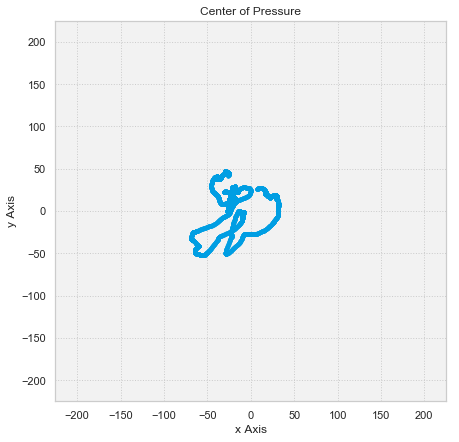

In [9]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {"axes.facecolor": ".95", "grid.linestyle": ':'})
plt.figure(figsize=(7, 7))
plt.scatter(center_of_pressure_x, center_of_pressure_y, marker=r'.', linewidths=1, c="#009EE3")
plt.xlabel("x Axis")
plt.ylabel("y Axis")
plt.title("Center of Pressure")
plt.xlim(-225,  225)
plt.ylim(-225,  225)
#plt.subplots_adjust(left=0.3, right=0.7)
plt.show()

from IPython.display import display, HTML
js = """<script>
//document.getElementsByClassName("ui-dialog-titlebar")[0].parentElement.parentElement.style.textAlign = "center";
document.getElementsByClassName("output_png")[0].style.textAlign = "center";
</script>"""
display(HTML(js))

This signal could then be analysed by a specialist to extract information regarding the posture of the subject or an algorithm could be developed to extract features from the signal and automatically assess about the patient's health.

With this notebook we saw how straightforward it is to calculate the center of pressure using the force platform given the information available in the sensor's datasheet.

<strong><span class="color7">We hope that you have enjoyed this guide. </span><span class="color2">biosignalsnotebooks</span><span class="color4"> is an environment in continuous expansion, so don't stop your journey and learn more with the remaining <a href="../MainFiles/biosignalsnotebooks.ipynb">Notebooks <img src="../../images/icons/link.png" width="10px" height="10px" style="display:inline"></a></span></strong> ! 

<hr>
<table width="100%">
    <tr>
        <td class="footer_logo">
            <img src="../../images/ost_logo.png" alt="biosignalsnotebooks | project logo [footer]">
        </td>
        <td width="40%" style="text-align:left">
            <a href="../MainFiles/aux_files/biosignalsnotebooks_presentation.pdf" target="_blank">&#9740; Project Presentation</a>
            <br>
            <a href="https://github.com/biosignalsplux/biosignalsnotebooks" target="_blank">&#9740; GitHub Repository</a>
            <br>
            <a href="https://pypi.org/project/biosignalsnotebooks/" target="_blank">&#9740; How to install biosignalsnotebooks Python package ?</a>
            <br>
            <a href="https://www.biosignalsplux.com/notebooks/Categories/MainFiles/signal_samples.ipynb">&#9740; Signal Library</a>
        </td>
        <td width="40%" style="text-align:left">
            <a href="https://www.biosignalsplux.com/notebooks/Categories/MainFiles/biosignalsnotebooks.ipynb">&#9740; Notebook Categories</a>
            <br>
            <a href="https://www.biosignalsplux.com/notebooks/Categories/MainFiles/by_diff.ipynb">&#9740; Notebooks by Difficulty</a>
            <br>
            <a href="https://www.biosignalsplux.com/notebooks/Categories/MainFiles/by_signal_type.ipynb">&#9740; Notebooks by Signal Type</a>
            <br>
            <a href="https://www.biosignalsplux.com/notebooks/Categories/MainFiles/by_tag.ipynb">&#9740; Notebooks by Tag</a>
        </td>
    </tr>
</table>

In [10]:
from biosignalsnotebooks.__notebook_support__ import css_style_apply
css_style_apply()

.................... CSS Style Applied to Jupyter Notebook .........................


In [11]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'],
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>